# E5. Image Similarity using embedding vector

**실습목차**    
1. 사진의 얼굴 영역 임베딩 벡터 추출   
    1-1. 사용할 함수 정의   
    1-2. custom 함수를 활용해 진행
    
2. 나랑 비슷한 연예인은 누구..?
3. Visualization of embedding vectors
4. 회고
 
**실습개요**
: face_recognition library를 활용해서 얼굴을 인식하고, face locations를 찾아 임베딩 벡터로 변환한 후 벡터 간 거리로 닮은 꼴을 찾아냅니다.

- "임베딩"이란..?

**실습 insight**


## 1. 사진의 얼굴 영역 임베딩 벡터 추출

In [1]:
!pip3 install face_recognition # 코랩에 face_recognition 패키지를 설치

In [2]:
#matplotlib에 한글 주석을 넣어주기 위해
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,794 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

In [30]:
# 필요한 패키지 불러오기

from PIL import Image
import face_recognition
import os
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import cv2

import unicodedata
def unicode(name):
  return unicodedata.normalize("NFC", name) #코랩에서는 왜인지.. 한글 파일이름이 한글 string이랑 비교하면 false가 나와서 unicode normalize를 해줬습니다.

In [4]:
plt.rc('font', family='NanumBarunGothic') 

In [7]:
!ls

drive  sample_data


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1-1. 사용할 함수 정의

* custom 함수 정의
    - get_cropped_face(path_dir): 사진에서 얼굴 영역을 잘라낸 후 PIL Image 로 변환해서 저장
    - get_face_embedding(image): face_recognition 의 face_encodings 함수로 잘라낸 얼굴 영역의 임베딩 벡터를 구하는 함수
    - get_face_embedding_dict(path_dir): 지정한 경로에 있는 이미지들에 대해 얼굴 임베딩 벡터를 구하고 딕셔너리로 저장
    - get_distance(name1, name2): 임베딩 벡터 간 거리를 구하는 함수
    - get_sort_key_func(name1): name1과 name2의 거리를 비교하는데, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 하는 함수
    - def get_nearest_face(name, top=5): 입력한 name과 닮은 사람을 순위별로 5위까지 나열하고 이미지로 출력해주는 함수.

In [13]:
# get_cropped_face 함수를 정의합니다.

def get_cropped_face(path_dir):
  '''
  face_recognition 패키지를 활용해 얼굴을 인식해 잘라내고,
  pillow의 Image.fromarray로 PIL Image로 변환 후 저장하는 함수입니다.

  path_dir: 읽어올 이미지가 있는 경로
  '''
  
  file_list = os.listdir(path_dir)
  cropped_face_dict={}       # 잘라준 얼굴영역 array를 모아줍니다.
  for i, file in tqdm(enumerate(file_list)):
    if file == "cropped": continue     # celebrity 디렉토리 안에 얼굴 영역을 자른 파일을 모아줄 cropped 디렉토리는 패스한다.
    file_name = os.path.splitext(file)[0]
    file_name = unicode(file_name)
    image = face_recognition.load_image_file(os.path.join(path_dir, file))
    face_locations = face_recognition.face_locations(image)

    if face_locations == []:
      print("얼굴 인식이 안되는 파일 제외:", file)
      continue

    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    cropped_face_dict["{}".format(file_name)] = cropped_face
    Image.fromarray(cropped_face).save("{}/cropped/{}.jpg".format(path_dir,file_name))  # PIL image 로 바꾼후 저장
  
  print("-----------------------------")
  print("face crop success")
  return cropped_face_dict

In [9]:
# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

# 디렉토리 내의 이미지에 대해 얼굴 임베딩 벡터를 딕셔너리로 저장
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in tqdm(file_list):
        img_path = os.path.join(dir_path, file)
        file_name = os.path.splitext(file)[0]
        file_name = unicode(file_name)
        embedding = get_face_embedding(cropped_face_dict[file_name])
        if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
            embedding_dict[file_name] = embedding[0]
        else:
          print("face detect 실패한 파일:", file)
    
    print("-----------------------------")
    print("embedding vector success\n")    
    return embedding_dict

In [10]:
# 두 개의 임베딩 벡터 사이의 거리를 구하는 함수를 정의합니다.
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

In [45]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)  
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))    # 입력한 name과 가까운 순으로 정렬
    im_name = cv2.imread(os.path.join(cropped_path,"{}.jpg".format(name)))
    im_name = cv2.resize(im_name, (200,200))

    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            print('입력한 이름: {}'.format(sorted_faces[i][0]))
            plt.imshow(cropped_face_dict[unicode(sorted_faces[i][0])])
            plt.show()
            print("-----------------------------")
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            print('대략 {}% 닮았네요!'.format(round((1-sort_key_func(sorted_faces[i][0]))*100))) # 재미를 위해 닮은 정도를 확률로 나타냈습니다.
            # 닮은 정도를 나타내는 식을 정해줬습니다: (1-임베딩 벡터 거리)*100
            plt.imshow(cropped_face_dict[unicode(sorted_faces[i][0])])
            plt.show()

            im_similar = cv2.imread(os.path.join(cropped_path,"{}.jpg".format(sorted_faces[i][0])))
            im_similar = cv2.resize(im_similar, (200,200))
            dst = cv2.addWeighted(im_name, 0.5, im_similar, 0.5, 0.0)  # 이미지를 겹쳐 보면서 얼마나 비슷한지 비교해 보려고 합니다.
            plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
            plt.show()
            print("-----------------------------")
    return sorted_faces      # 정렬한 리스트 반환

## 1-2. custom 함수를 활용해 진행

In [16]:
path_dir = '/content/drive/MyDrive/celebrity'   # 연예인 사진들을 모아둔 파일 경로를 불러옵니다.
os.mkdir(os.path.join(path_dir, 'cropped')) # 얼굴만 자른 사진을 모아줄 하위 디렉토리 생성

cropped_face_dict = get_cropped_face(path_dir)
print("얼굴 인식 성공한 파일 개수:",len(cropped_face_dict))

19it [00:06,  2.86it/s]

얼굴 인식이 안되는 파일 제외: 이종현.jpg


44it [00:14,  2.89it/s]

얼굴 인식이 안되는 파일 제외: 이주영.jpg


54it [00:17,  3.07it/s]

얼굴 인식이 안되는 파일 제외: 심은경.jpg


61it [00:20,  2.94it/s]

얼굴 인식이 안되는 파일 제외: 손호준.jpg


66it [00:22,  2.90it/s]

얼굴 인식이 안되는 파일 제외: 이민정.jpg


118it [00:40,  2.99it/s]

얼굴 인식이 안되는 파일 제외: 성준.jpg


119it [00:40,  2.90it/s]

얼굴 인식이 안되는 파일 제외: 유호린.jpg


135it [00:46,  2.74it/s]

얼굴 인식이 안되는 파일 제외: 민도희.jpg


148it [00:50,  2.90it/s]

얼굴 인식이 안되는 파일 제외: 김희애.jpg


184it [01:02,  2.94it/s]

얼굴 인식이 안되는 파일 제외: 진서연.jpg


236it [01:20,  2.96it/s]

얼굴 인식이 안되는 파일 제외: 이재은.jpg


279it [01:34,  2.58it/s]

얼굴 인식이 안되는 파일 제외: 이진.jpg


291it [01:38,  2.88it/s]

얼굴 인식이 안되는 파일 제외: 강민경 2.jpg


323it [01:49,  3.00it/s]

얼굴 인식이 안되는 파일 제외: 안효섭.jpg


341it [01:55,  2.96it/s]

얼굴 인식이 안되는 파일 제외: 남규리.jpg


379it [02:09,  3.02it/s]

얼굴 인식이 안되는 파일 제외: 지이수.jpg


385it [02:11,  3.07it/s]

얼굴 인식이 안되는 파일 제외: 이희진.jpg


462it [02:36,  3.46it/s]

얼굴 인식이 안되는 파일 제외: 강균성.jpg


496it [02:47,  3.11it/s]

얼굴 인식이 안되는 파일 제외: 제이홉 2.jpg


505it [02:50,  3.72it/s]

얼굴 인식이 안되는 파일 제외: 정수라.jpg


507it [02:51,  3.10it/s]

얼굴 인식이 안되는 파일 제외: 김규종.jpg


515it [02:53,  3.34it/s]

얼굴 인식이 안되는 파일 제외: 로이킴.jpg


562it [03:08,  3.67it/s]

얼굴 인식이 안되는 파일 제외: SE7EN.jpg


567it [03:09,  3.55it/s]

얼굴 인식이 안되는 파일 제외: 하현우 2.jpg


573it [03:11,  3.11it/s]

얼굴 인식이 안되는 파일 제외: 길학미.jpg


577it [03:12,  3.45it/s]

얼굴 인식이 안되는 파일 제외: 휘성.jpg


588it [03:16,  3.50it/s]

얼굴 인식이 안되는 파일 제외: 문명진.jpg


622it [03:26,  3.81it/s]

얼굴 인식이 안되는 파일 제외: 전진.jpg


625it [03:27,  3.39it/s]

얼굴 인식이 안되는 파일 제외: 구윤회.jpg


627it [03:28,  3.52it/s]

얼굴 인식이 안되는 파일 제외: 김윤아.jpg


628it [03:28,  3.43it/s]

얼굴 인식이 안되는 파일 제외: 나미.jpg


630it [03:29,  3.03it/s]

얼굴 인식이 안되는 파일 제외: 류재현.jpg


631it [03:29,  3.27it/s]

얼굴 인식이 안되는 파일 제외: 윤민수.jpg


635it [03:30,  3.12it/s]

얼굴 인식이 안되는 파일 제외: 이광필.jpg


647it [03:33,  3.59it/s]

얼굴 인식이 안되는 파일 제외: 문지은.jpg


654it [03:36,  3.59it/s]

얼굴 인식이 안되는 파일 제외: 김필.jpg


660it [03:38,  2.99it/s]

얼굴 인식이 안되는 파일 제외: 강타.jpg


670it [03:41,  3.44it/s]

얼굴 인식이 안되는 파일 제외: 정준영.jpg


696it [03:49,  3.45it/s]

얼굴 인식이 안되는 파일 제외: 이준오.jpg


700it [03:50,  3.39it/s]

얼굴 인식이 안되는 파일 제외: 김경록.jpg


715it [03:55,  3.41it/s]

얼굴 인식이 안되는 파일 제외: 한영애.jpg


739it [04:02,  3.83it/s]

얼굴 인식이 안되는 파일 제외: 바비 킴.jpg


744it [04:04,  3.09it/s]

얼굴 인식이 안되는 파일 제외: 소찬휘.jpg


746it [04:04,  3.25it/s]

얼굴 인식이 안되는 파일 제외: 백청강.jpg


758it [04:08,  3.25it/s]

얼굴 인식이 안되는 파일 제외: 강이채.jpg


759it [04:08,  3.47it/s]

얼굴 인식이 안되는 파일 제외: 타블로.jpg


761it [04:09,  3.52it/s]

얼굴 인식이 안되는 파일 제외: 투컷.jpg


767it [04:10,  3.52it/s]

얼굴 인식이 안되는 파일 제외: 소명.jpg


773it [04:12,  3.02it/s]

얼굴 인식이 안되는 파일 제외: 김종완.jpg


798it [04:19,  3.82it/s]

얼굴 인식이 안되는 파일 제외: 윤닭.jpg


799it [04:20,  3.94it/s]

얼굴 인식이 안되는 파일 제외: Zion.T.jpg


800it [04:20,  3.41it/s]

얼굴 인식이 안되는 파일 제외: 윤미래.jpg


801it [04:20,  3.12it/s]

얼굴 인식이 안되는 파일 제외: 나윤권.jpg


808it [04:22,  3.13it/s]

얼굴 인식이 안되는 파일 제외: 지아.jpg


815it [04:25,  3.41it/s]

얼굴 인식이 안되는 파일 제외: T.O.P.jpg


823it [04:27,  3.07it/s]

얼굴 인식이 안되는 파일 제외: 헤이즈.jpg


839it [04:32,  3.16it/s]

얼굴 인식이 안되는 파일 제외: 손성희.jpg


847it [04:35,  3.40it/s]

얼굴 인식이 안되는 파일 제외: 최락.jpg


857it [04:38,  3.13it/s]

얼굴 인식이 안되는 파일 제외: 주학년.jpg


865it [04:40,  3.21it/s]

얼굴 인식이 안되는 파일 제외: 뉴.jpg


869it [04:42,  3.14it/s]

얼굴 인식이 안되는 파일 제외: 박재범 2.jpg


871it [04:42,  2.85it/s]

얼굴 인식이 안되는 파일 제외: 서태지.jpg


874it [04:43,  3.28it/s]

얼굴 인식이 안되는 파일 제외: 타루.jpg


895it [04:50,  3.58it/s]

얼굴 인식이 안되는 파일 제외: 박효신.jpg


904it [04:52,  3.57it/s]

얼굴 인식이 안되는 파일 제외: 김형중.jpg


912it [04:55,  3.33it/s]

얼굴 인식이 안되는 파일 제외: 손진영.jpg


914it [04:56,  2.92it/s]

얼굴 인식이 안되는 파일 제외: 임재범.jpg


917it [04:56,  3.01it/s]

얼굴 인식이 안되는 파일 제외: 손가인.jpg


928it [05:00,  3.55it/s]

얼굴 인식이 안되는 파일 제외: 이은하.jpg


933it [05:01,  3.63it/s]

얼굴 인식이 안되는 파일 제외: 이선희.jpg


957it [05:08,  3.75it/s]

얼굴 인식이 안되는 파일 제외: 노유민.jpg


959it [05:09,  3.45it/s]

얼굴 인식이 안되는 파일 제외: 이가희.jpg


964it [05:11,  3.15it/s]

얼굴 인식이 안되는 파일 제외: 원필.jpg


970it [05:12,  3.31it/s]

얼굴 인식이 안되는 파일 제외: 최용준.jpg


973it [05:13,  3.39it/s]

얼굴 인식이 안되는 파일 제외: 효연.jpg


989it [05:18,  3.61it/s]

얼굴 인식이 안되는 파일 제외: 조용필.jpg


994it [05:20,  3.03it/s]

얼굴 인식이 안되는 파일 제외: 우순실.jpg


1061it [05:45,  3.20it/s]

얼굴 인식이 안되는 파일 제외: 남궁민.jpg


1165it [06:20,  3.04it/s]

얼굴 인식이 안되는 파일 제외: 박지예.jpg


1175it [06:24,  3.16it/s]

얼굴 인식이 안되는 파일 제외: 윤승아.jpg


1190it [06:29,  3.20it/s]

얼굴 인식이 안되는 파일 제외: 배용준.jpg


1234it [06:44,  3.15it/s]

얼굴 인식이 안되는 파일 제외: 이재윤.jpg


1265it [06:54,  2.78it/s]

얼굴 인식이 안되는 파일 제외: 김우빈.jpg


1303it [07:07,  2.99it/s]

얼굴 인식이 안되는 파일 제외: 심희섭.jpg


1393it [07:37,  2.86it/s]

얼굴 인식이 안되는 파일 제외: 김범.jpg


1394it [07:38,  3.02it/s]

얼굴 인식이 안되는 파일 제외: 이일재.jpg


1431it [07:50,  3.13it/s]

얼굴 인식이 안되는 파일 제외: 유준후.jpg


1455it [07:58,  3.14it/s]

얼굴 인식이 안되는 파일 제외: 명계남.jpg


1558it [08:33,  2.99it/s]

얼굴 인식이 안되는 파일 제외: 김아중.jpg


1586it [08:43,  2.97it/s]

얼굴 인식이 안되는 파일 제외: 이준.jpg


1601it [08:48,  2.75it/s]

얼굴 인식이 안되는 파일 제외: 조현재.jpg


1629it [08:57,  3.21it/s]

얼굴 인식이 안되는 파일 제외: 조권.jpg


1688it [09:17,  3.16it/s]

얼굴 인식이 안되는 파일 제외: 박정학.jpg


1704it [09:22,  2.95it/s]

얼굴 인식이 안되는 파일 제외: 김윤석.jpg


1724it [09:29,  2.76it/s]

얼굴 인식이 안되는 파일 제외: 허정민.jpg


1750it [09:38,  3.20it/s]

얼굴 인식이 안되는 파일 제외: 김성오.jpg


1767it [09:44,  2.91it/s]

얼굴 인식이 안되는 파일 제외: 서강준 2.jpg


1785it [09:50,  3.13it/s]

얼굴 인식이 안되는 파일 제외: 김영대.jpg


1790it [09:51,  3.00it/s]

얼굴 인식이 안되는 파일 제외: 선우선.jpg


1827it [10:04,  2.88it/s]

얼굴 인식이 안되는 파일 제외: 한지안.jpg


1840it [10:08,  3.49it/s]

얼굴 인식이 안되는 파일 제외: 공유 2.jpg


1870it [10:19,  3.08it/s]

얼굴 인식이 안되는 파일 제외: 연정훈.jpg


1890it [10:26,  3.06it/s]

얼굴 인식이 안되는 파일 제외: 류진 2.jpg


1975it [10:54,  3.08it/s]

얼굴 인식이 안되는 파일 제외: 최진실.jpg


1984it [10:57,  2.86it/s]

얼굴 인식이 안되는 파일 제외: 지진희.jpg


2281it [14:02,  1.40it/s]

얼굴 인식이 안되는 파일 제외: 산들.jpeg


2315it [14:18,  3.08it/s]

얼굴 인식이 안되는 파일 제외: 오승윤.jpg


2370it [14:35,  2.71it/s]

-----------------------------
face crop success
얼굴 인식 성공한 파일 개수: 2225


In [17]:
cropped_path = os.path.join(path_dir, "cropped")

embedding_dict = get_face_embedding_dict(cropped_path)
print("임베딩 벡터 구한 얼굴 개수: ", len(embedding_dict))
print("-----------------------------")
file_list = os.listdir(cropped_path)

print(file_list)
print(embedding_dict.keys())

  1%|          | 25/2225 [00:06<1:52:13,  3.06s/it]

face detect 실패한 파일: 오한결.jpg
face detect 실패한 파일: 곽시양.jpg


  3%|▎         | 75/2225 [00:06<26:33,  1.35it/s]

face detect 실패한 파일: 최태준.jpg
face detect 실패한 파일: 박형식.jpg
face detect 실패한 파일: 권은수.jpg
face detect 실패한 파일: 권소현.jpg
face detect 실패한 파일: 하도권.jpg


  5%|▍         | 111/2225 [00:07<09:09,  3.85it/s]

face detect 실패한 파일: 송승헌.jpg
face detect 실패한 파일: 신세경.jpg


  7%|▋         | 148/2225 [00:07<03:16, 10.55it/s]

face detect 실패한 파일: 기주봉.jpg
face detect 실패한 파일: 이훈.jpg


  8%|▊         | 172/2225 [00:07<01:44, 19.61it/s]

face detect 실패한 파일: 이주안.jpg
face detect 실패한 파일: 김일우.jpg


 10%|▉         | 222/2225 [00:08<00:37, 53.82it/s]

face detect 실패한 파일: 김성철.jpg
face detect 실패한 파일: 이승연.jpg
face detect 실패한 파일: 곽지민.jpg


 11%|█         | 249/2225 [00:08<00:25, 76.20it/s]

face detect 실패한 파일: 박보검 2.jpg
face detect 실패한 파일: 김재원.jpg


 13%|█▎        | 290/2225 [00:08<00:18, 105.23it/s]

face detect 실패한 파일: 신은경.jpg
face detect 실패한 파일: 이태리.jpg
face detect 실패한 파일: 송하윤.jpg
face detect 실패한 파일: 최윤소.jpg
face detect 실패한 파일: 한지혜.jpg
face detect 실패한 파일: 김성경.jpg


 16%|█▌        | 346/2225 [00:09<00:14, 127.40it/s]

face detect 실패한 파일: 정욱진.jpg
face detect 실패한 파일: 김민주.jpg
face detect 실패한 파일: 나혜미.jpg
face detect 실패한 파일: 윤태영.jpg
face detect 실패한 파일: 서우진.jpg
face detect 실패한 파일: 조진웅.jpg
face detect 실패한 파일: 박지윤.jpg
face detect 실패한 파일: 손유동.jpg


 16%|█▌        | 360/2225 [00:09<00:15, 121.40it/s]

face detect 실패한 파일: 경인선.jpg
face detect 실패한 파일: 유일.jpg
face detect 실패한 파일: 한태일.jpg
face detect 실패한 파일: 이채영.jpg
face detect 실패한 파일: 효민.jpg
face detect 실패한 파일: 

 18%|█▊        | 403/2225 [00:09<00:13, 130.77it/s]

김단우.jpg
face detect 실패한 파일: 이이경.jpg
face detect 실패한 파일: 류한비.jpg


 19%|█▉        | 431/2225 [00:09<00:13, 128.83it/s]

face detect 실패한 파일: 지현우.jpg
face detect 실패한 파일: 여진구.jpg
face detect 실패한 파일: 김진이.jpg
face detect 실패한 파일: 이현.jpg


 21%|██▏       | 473/2225 [00:10<00:13, 126.12it/s]

face detect 실패한 파일: 유승우.jpg
face detect 실패한 파일: 레이지.jpg
face detect 실패한 파일: 김승미.jpg
face detect 실패한 파일: 나비.jpg
face detect 실패한 파일: RM 2.jpg


 23%|██▎       | 514/2225 [00:10<00:13, 125.13it/s]

face detect 실패한 파일: 이해리.jpg
face detect 실패한 파일: 적우.jpg
face detect 실패한 파일: 유정석.jpg
face detect 실패한 파일: 유미소.jpg
face detect 실패한 파일: 박서진.jpg
face detect 실패한 파일: 조원민.jpg
face detect 실패한 파일: 조은새.jpg


 26%|██▌       | 574/2225 [00:10<00:12, 137.09it/s]

face detect 실패한 파일: 브래드.jpg
face detect 실패한 파일: 황규영.jpg
face detect 실패한 파일: KCM.jpg
face detect 실패한 파일: 벤.jpg
face detect 실패한 파일: 나희경.jpg
face detect 실패한 파일: 제니 2.jpg
face detect 실패한 파일: 건지.jpg
face detect 실패한 파일: 요조.jpg


 27%|██▋       | 603/2225 [00:11<00:11, 137.31it/s]

face detect 실패한 파일: 나얼.jpg
face detect 실패한 파일: 윤건.jpg
face detect 실패한 파일: 로티플스카이.jpg
face detect 실패한 파일: 김경현.jpg


 30%|██▉       | 660/2225 [00:11<00:11, 134.21it/s]

face detect 실패한 파일: 정준일.jpg
face detect 실패한 파일: 하진.jpg
face detect 실패한 파일: 이박사.jpg
face detect 실패한 파일: 김동률.jpg
face detect 실패한 파일: 선우정아.jpg
face detect 실패한 파일: 웅산.jpg
face detect 실패한 파일: 한영주.jpg
face detect 실패한 파일: 유재하.jpg
face detect 실패한 파일: 유열.jpg


 31%|███       | 688/2225 [00:11<00:11, 133.47it/s]

face detect 실패한 파일: 신용재.jpg
face detect 실패한 파일: 유영진.jpg
face detect 실패한 파일: 이진성.jpg


 32%|███▏      | 716/2225 [00:11<00:12, 123.87it/s]

face detect 실패한 파일: 이소은.jpg
face detect 실패한 파일: 미쓰라.jpg
face detect 실패한 파일: 별.jpg


 34%|███▍      | 760/2225 [00:12<00:11, 126.07it/s]

face detect 실패한 파일: 숙현.jpg
face detect 실패한 파일: 송창식.jpg
face detect 실패한 파일: BUMZU.jpg
face detect 실패한 파일: 신해철.jpg
face detect 실패한 파일: 선미.jpg
face detect 실패한 파일: 하리.jpg
face detect 실패한 파일: 카이 2.jpg
face detect 실패한 파일: G-DRAGON.jpg
face detect 실패한 파일: 대성.jpg
face detect 실패한 파일: 정다경.jpg


 36%|███▌      | 806/2225 [00:12<00:10, 134.90it/s]

face detect 실패한 파일: 김예림.jpg
face detect 실패한 파일: 루시드폴.jpg
face detect 실패한 파일: 유영석.jpg
face detect 실패한 파일: 영훈.jpg
face detect 실패한 파일: 현재.jpg
face detect 실패한 파일: 상연.jpg
face detect 실패한 파일: 큐.jpg
face detect 실패한 파일: 제이콥.jpg
face detect 실패한 파일: 강승윤.jpg
face detect 실패한 파일: 세정.jpg
face detect 실패한 파일: 요아리.jpg


 38%|███▊      | 849/2225 [00:12<00:10, 128.09it/s]

face detect 실패한 파일: 샤넌.jpg


 40%|████      | 891/2225 [00:13<00:10, 129.16it/s]

face detect 실패한 파일: 마리오.jpg
face detect 실패한 파일: 홍진영.jpg
face detect 실패한 파일: 효린.jpg
face detect 실패한 파일: 도운.jpg
face detect 실패한 파일: 박정현.jpg
face detect 실패한 파일: 임희숙.jpg


 41%|████▏     | 921/2225 [00:13<00:09, 132.40it/s]

face detect 실패한 파일: 한승희.jpg


 43%|████▎     | 949/2225 [00:13<00:13, 94.01it/s]

face detect 실패한 파일: 양동근.jpg
face detect 실패한 파일: 권은아.jpg
face detect 실패한 파일: 박인환.jpg


 44%|████▍     | 988/2225 [00:14<00:11, 109.94it/s]

face detect 실패한 파일: 정동화.jpg
face detect 실패한 파일: 하지원.jpg
face detect 실패한 파일: 유혜정.jpg
face detect 실패한 파일: 손우현.jpg
face detect 실패한 파일: 임주환.jpg
face detect 실패한 파일: 전태수.jpg


 46%|████▋     | 1031/2225 [00:14<00:09, 127.72it/s]

face detect 실패한 파일: 김솔비.jpg
face detect 실패한 파일: 지율.jpg
face detect 실패한 파일: 이정신.jpg


 48%|████▊     | 1074/2225 [00:14<00:08, 134.09it/s]

face detect 실패한 파일: 최명빈.jpg
face detect 실패한 파일: 신민아.jpg
face detect 실패한 파일: 최강창민.jpg
face detect 실패한 파일: 최성준.jpg


 50%|█████     | 1116/2225 [00:15<00:09, 122.63it/s]

face detect 실패한 파일: 오광록.jpg
face detect 실패한 파일: 최유진.jpg
face detect 실패한 파일: 김명준.jpg
face detect 실패한 파일: 

 51%|█████▏    | 1144/2225 [00:15<00:09, 115.33it/s]

최성국.jpg
face detect 실패한 파일: 태현실.jpg
face detect 실패한 파일: 서인석.jpg
face detect 실패한 파일: 서지혜.jpg


 55%|█████▌    | 1227/2225 [00:16<00:07, 132.05it/s]

face detect 실패한 파일: 하나경.jpg
face detect 실패한 파일: 김정민.jpg
face detect 실패한 파일: 노태엽.jpg
face detect 실패한 파일: 윤지민.jpg


 56%|█████▋    | 1257/2225 [00:16<00:07, 127.90it/s]

face detect 실패한 파일: 재희.jpg
face detect 실패한 파일: 최민수.jpg
face detect 실패한 파일: 한그루.jpg
face detect 실패한 파일: 강봉성.jpg
face detect 실패한 파일: 김대명.jpg


 58%|█████▊    | 1285/2225 [00:16<00:07, 131.38it/s]

face detect 실패한 파일: 김지은.jpg
face detect 실패한 파일: 황정음.jpg


 60%|██████    | 1339/2225 [00:17<00:08, 104.48it/s]

face detect 실패한 파일: 최종환.jpg
face detect 실패한 파일: 김규리.jpg
face detect 실패한 파일: 민지아.jpg


 62%|██████▏   | 1380/2225 [00:17<00:06, 121.34it/s]

face detect 실패한 파일: 현우.jpg
face detect 실패한 파일: 손태영.jpg
face detect 실패한 파일: 이장우.jpg


 63%|██████▎   | 1407/2225 [00:17<00:06, 124.35it/s]

face detect 실패한 파일: 김진엽.jpg
face detect 실패한 파일: 임지규.jpg
face detect 실패한 파일: 남다름.jpg
face detect 실패한 파일: 황가람.jpg


 65%|██████▌   | 1448/2225 [00:17<00:07, 110.29it/s]

face detect 실패한 파일: 도상우.jpg
face detect 실패한 파일: 설인아.jpg
face detect 실패한 파일: 김수정.jpg
face detect 실패한 파일: 김이지.jpg


 67%|██████▋   | 1499/2225 [00:18<00:06, 120.20it/s]

face detect 실패한 파일: 강지환.jpg
face detect 실패한 파일: 김세정.jpg


 69%|██████▉   | 1538/2225 [00:18<00:05, 123.71it/s]

face detect 실패한 파일: 윤시윤.jpg
face detect 실패한 파일: 이필모.jpg
face detect 실패한 파일: 이상인.jpg
face detect 실패한 파일: 랑연.jpg
face detect 실패한 파일:

 70%|███████   | 1565/2225 [00:18<00:05, 126.68it/s]

 박시진.jpg
face detect 실패한 파일: 이현우.jpg
face detect 실패한 파일: 김혜은.jpg
face detect 실패한 파일: 김강훈.jpg


 72%|███████▏  | 1604/2225 [00:19<00:05, 118.27it/s]

face detect 실패한 파일: 이규형.jpg


 73%|███████▎  | 1628/2225 [00:19<00:05, 113.59it/s]

face detect 실패한 파일: 전수경.jpg
face detect 실패한 파일: 최원홍.jpg


 75%|███████▍  | 1665/2225 [00:19<00:04, 114.81it/s]

face detect 실패한 파일: 여민정.jpg
face detect 실패한 파일: 정겨운.jpg
face detect 실패한 파일: 한주완.jpg
face detect 실패한 파일: 임주은.jpg


 78%|███████▊  | 1728/2225 [00:20<00:04, 118.30it/s]

face detect 실패한 파일: 김명수.jpg
face detect 실패한 파일: 이재균.jpg
face detect 실패한 파일: 최명길.jpg


 80%|████████  | 1782/2225 [00:20<00:03, 119.42it/s]

face detect 실패한 파일: 지유.jpg
face detect 실패한 파일: 이광수 2.jpg
face detect 실패한 파일: 최규환.jpg
face detect 실패한 파일: 이준영.jpg


 81%|████████▏ | 1809/2225 [00:20<00:03, 117.78it/s]

face detect 실패한 파일: 송은영.jpg
face detect 실패한 파일: 김남길.jpg
face detect 실패한 파일: 윤현민.jpg


 83%|████████▎ | 1846/2225 [00:21<00:03, 116.60it/s]

face detect 실패한 파일: 송채환.jpg
face detect 실패한 파일: 반소영.jpg
face detect 실패한 파일: 권화운.jpg
face detect 실패한 파일: 차청화.jpg


 85%|████████▌ | 1896/2225 [00:21<00:03, 103.66it/s]

face detect 실패한 파일: 차수연.jpg


 86%|████████▌ | 1915/2225 [00:23<00:10, 29.56it/s]

face detect 실패한 파일: 신태용.jpg


 90%|█████████ | 2010/2225 [00:27<00:08, 24.87it/s]

face detect 실패한 파일: 사무엘 L 잭슨.jpg


 91%|█████████ | 2030/2225 [00:28<00:06, 31.22it/s]

face detect 실패한 파일: 이승환.jpg


 94%|█████████▍| 2092/2225 [00:31<00:09, 13.40it/s]

face detect 실패한 파일: 신비.jpg


 95%|█████████▌| 2122/2225 [00:33<00:04, 22.40it/s]

face detect 실패한 파일: 도아.jpg
face detect 실패한 파일: 한효주.jpg


 98%|█████████▊| 2170/2225 [00:34<00:02, 20.86it/s]

face detect 실패한 파일: 고윤.jpg
face detect 실패한 파일: 유준상.jpg
face detect 실패한 파일: 남정임.jpg
face detect 실패한 파일: 강예빈.jpg
face detect 실패한 파일: 김지우.jpg


 99%|█████████▉| 2208/2225 [00:35<00:00, 45.73it/s]

face detect 실패한 파일: 이유비.jpg
face detect 실패한 파일: 김예원.jpg


100%|██████████| 2225/2225 [00:35<00:00, 62.82it/s]

-----------------------------
embedding vector success

임베딩 벡터 구한 얼굴 개수:  2020
-----------------------------
['문성일.jpg', '황해.jpg', '박주미.jpg', '이정은.jpg', '오한결.jpg', '박소현.jpg', '박정수.jpg', '박신아.jpg', '무진성.jpg', '최철호.jpg', '남성진.jpg', '정링컨.jpg', '정혜영.jpg', '김민.jpg', '남보라.jpg', '문채원.jpg', '이지아.jpg', '이고은.jpg', '정종준.jpg', '양진성.jpg', '강은탁.jpg', '송강.jpg', '김성균.jpg', '강다현.jpg', '김단율.jpg', '박보영 2.jpg', '최윤영.jpg', '곽시양.jpg', '박준금.jpg', '최태준.jpg', '손숙.jpg', '고인범.jpg', '하연주.jpg', '한지완.jpg', '송일국.jpg', '주지훈.jpg', '이재룡.jpg', '최민호.jpg', '김보라.jpg', '임창정.jpg', '김예령.jpg', '김영광.jpg', '윤균상 2.jpg', '박세완.jpg', '강성민.jpg', '송지효.jpg', '지일주.jpg', '임원희.jpg', '조은숙.jpg', '선우은숙.jpg', '장원영.jpg', '임세미.jpg', '이상아.jpg', '박형식.jpg', '권은수.jpg', '공효진 2.

In [18]:
print("나는 내 사진과 얼마나 닮았을까?")
get_distance('나', '나2')

나는 내 사진과 얼마나 닮았을까?


0.31827305501881903


샘플1: 설수현


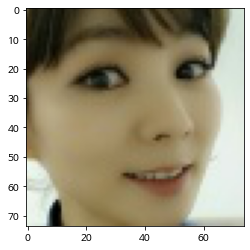


샘플2: 김희원


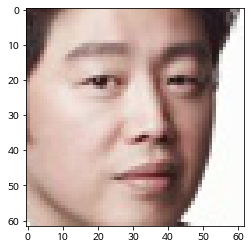

-----------------------------
설수현, 김희원 둘이 얼마나 닮았을까? 0.626175933119983


In [19]:
# file_list에서 랜덤으로 두개의 이미지와 embedding vector를 확인하고, 거리 구하기
sample = random.sample(file_list, 2)   # random으로 file_list에서 2개 파일을 추출합니다.

for idx,file in enumerate(sample):
  file_name = unicode(os.path.splitext(file)[0])
  print("\n샘플{}:".format(idx+1),file_name)
  plt.imshow(cropped_face_dict[file_name])
  plt.show()

print("-----------------------------")
name1=unicode(os.path.splitext(sample[0])[0])
name2=unicode(os.path.splitext(sample[1])[0])
print("{}, {} 둘이 얼마나 닮았을까?".format(name1, name2), get_distance(name1, name2))

- 같은 사람의 임베딩 벡터 거리는 0.3 정도로 나왔고, 닮았으면 거리가 더 짧고, 닮지 않았으면 거리가 더 길게 나옵니다.

# 2. 나랑 비슷한 연예인은 누구..?

- 위에서 정의한 get_nearest_face 함수를 사용해서 내 사진과 비슷한 연예인 얼굴을 찾아봅시다.

입력한 이름: 나


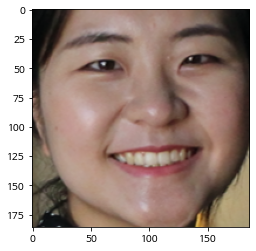

-----------------------------
순위 1 : 이름(나2), 거리(0.31827305501881903)
대략 68% 닮았네요!


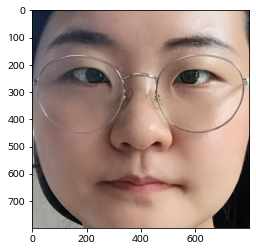

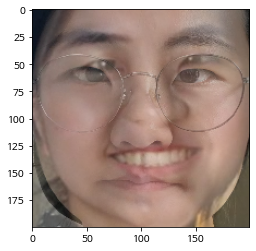

-----------------------------
순위 2 : 이름(성민준), 거리(0.4292831811766916)
대략 57% 닮았네요!


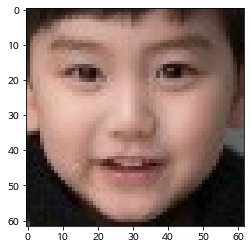

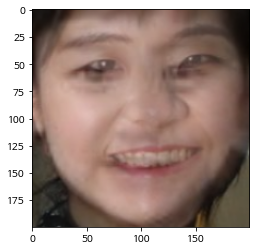

-----------------------------
순위 3 : 이름(안소희), 거리(0.4361201515293025)
대략 56% 닮았네요!


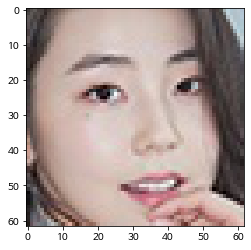

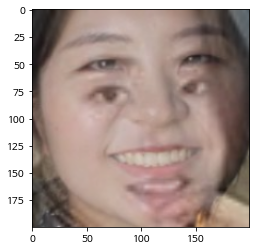

-----------------------------
순위 4 : 이름(박선주), 거리(0.443414911729719)
대략 56% 닮았네요!


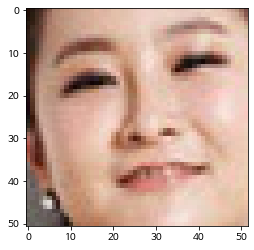

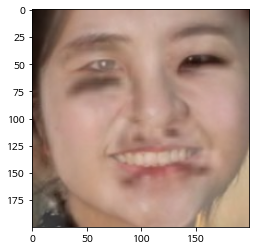

-----------------------------
순위 5 : 이름(노영심), 거리(0.44361711369335355)
대략 56% 닮았네요!


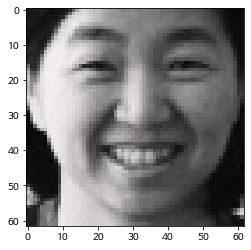

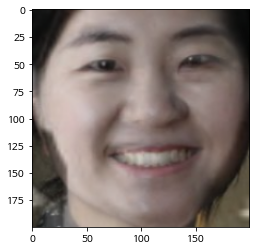

-----------------------------


In [46]:
nearest = get_nearest_face('나')   # 입력한 이름인 '나'의 image 와 닮은 구석이 많은 5개 이미지를 출력해줍니다.

- 흠... 제 생각엔 나름 비슷한 구석이 있는 것도 같은데 어떠신가요..?
- 이미지를 겹쳐서 시각화하려고 했는데, 눈/코/입 위치가 안맞아서 조금 괴상한 얼굴 사진이 되어버렸습니다. 겹쳐 보면 어디가 어떻게 비슷한지 보일 것 같았는데 다른 방법도 찾아봐야겠습니다.

# 3. Visualization of embedding vectors

- 임베딩 벡터를 visualization할 방법에 대해서 고민했는데, 노드에서 배웠던 PCA, t-SNE에 대해서 찾아봤습니다. 고차원 벡터를 저차원으로 압축해준 뒤, 벡터 간 거리가 가까울수록 x-y 좌표평면에 가깝게 배치하는 원리로 작동합니다. 다음 링크를 참고해서 코드를 작성했습니다.
(https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne) 
단, 이 링크에서는 nlp 에서 word2vec 을 해준 뒤 t-SNE로 시각화했으며 word2vec 부분을 빼고 embedding vector 를 좌표평면에 나타내는 코드만 참고했습니다. 그렇기에 조금 미숙할 수 있습니다. 이 링크를 참고한 전제는, 자연어든 이미지든 고차원 벡터를 저차원으로 embedding vector로 변환해주었다면 거리를 계산하는 알고리즘은 같은 원리일 것이라는 제 생각이었습니다.
- 앞에서 구해준 각 사람의 얼굴 임베딩 벡터를 담은 embedding_dict를 sorted한 리스트에서 label과 vector를 가져와서 시각화해주었습니다.

In [22]:
# TSNE 모델을 이용해서 구해준 embedding vector를 visualize해봅니다.

from sklearn.manifold import TSNE
from tqdm import tqdm

labels = []
vectors = []

for image in tqdm(nearest):
  vectors.append(image[1])
  labels.append(image[0])
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(vectors)

100%|██████████| 2020/2020 [00:00<00:00, 414080.16it/s]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


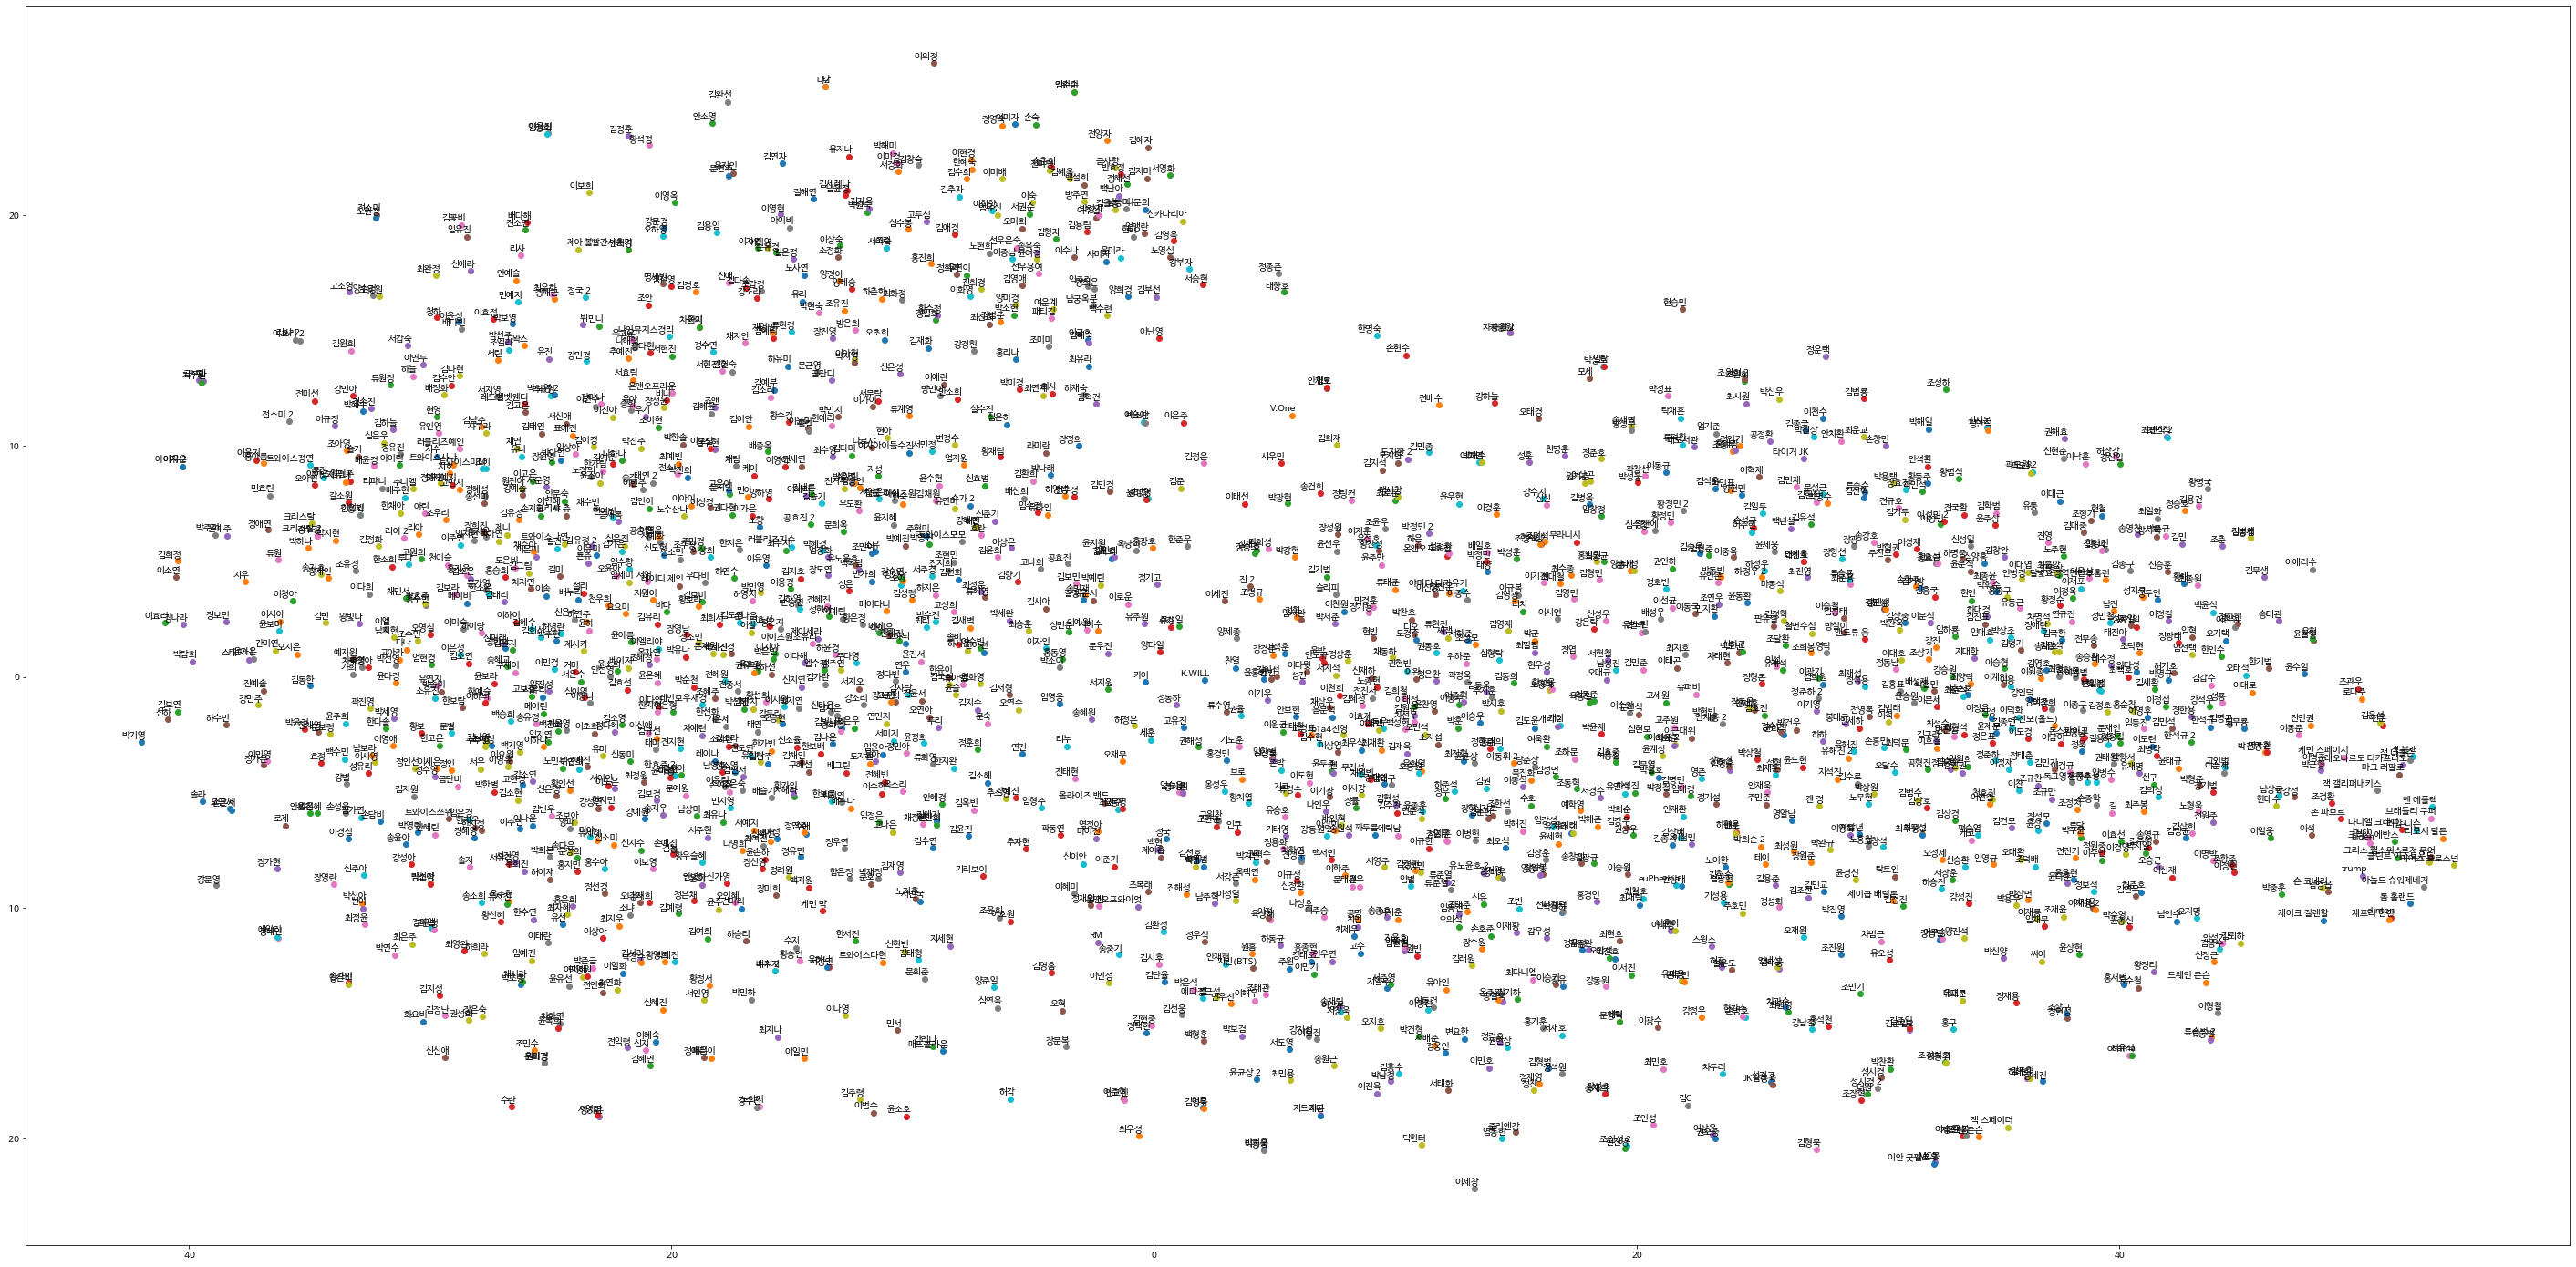

In [25]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(50, 25)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
plt.show()

- 데이터가 많아서 한눈에 다 들어오지는 않지만, 왼쪽에는 주로 여자 연예인들이 모여 있고, 오른쪽에는 남자 연예인들이 분포하고 있습니다. 아무래도 성별이 같은 사람들끼리 더 비슷한 구석이 많으니까요.
확대한 사진:
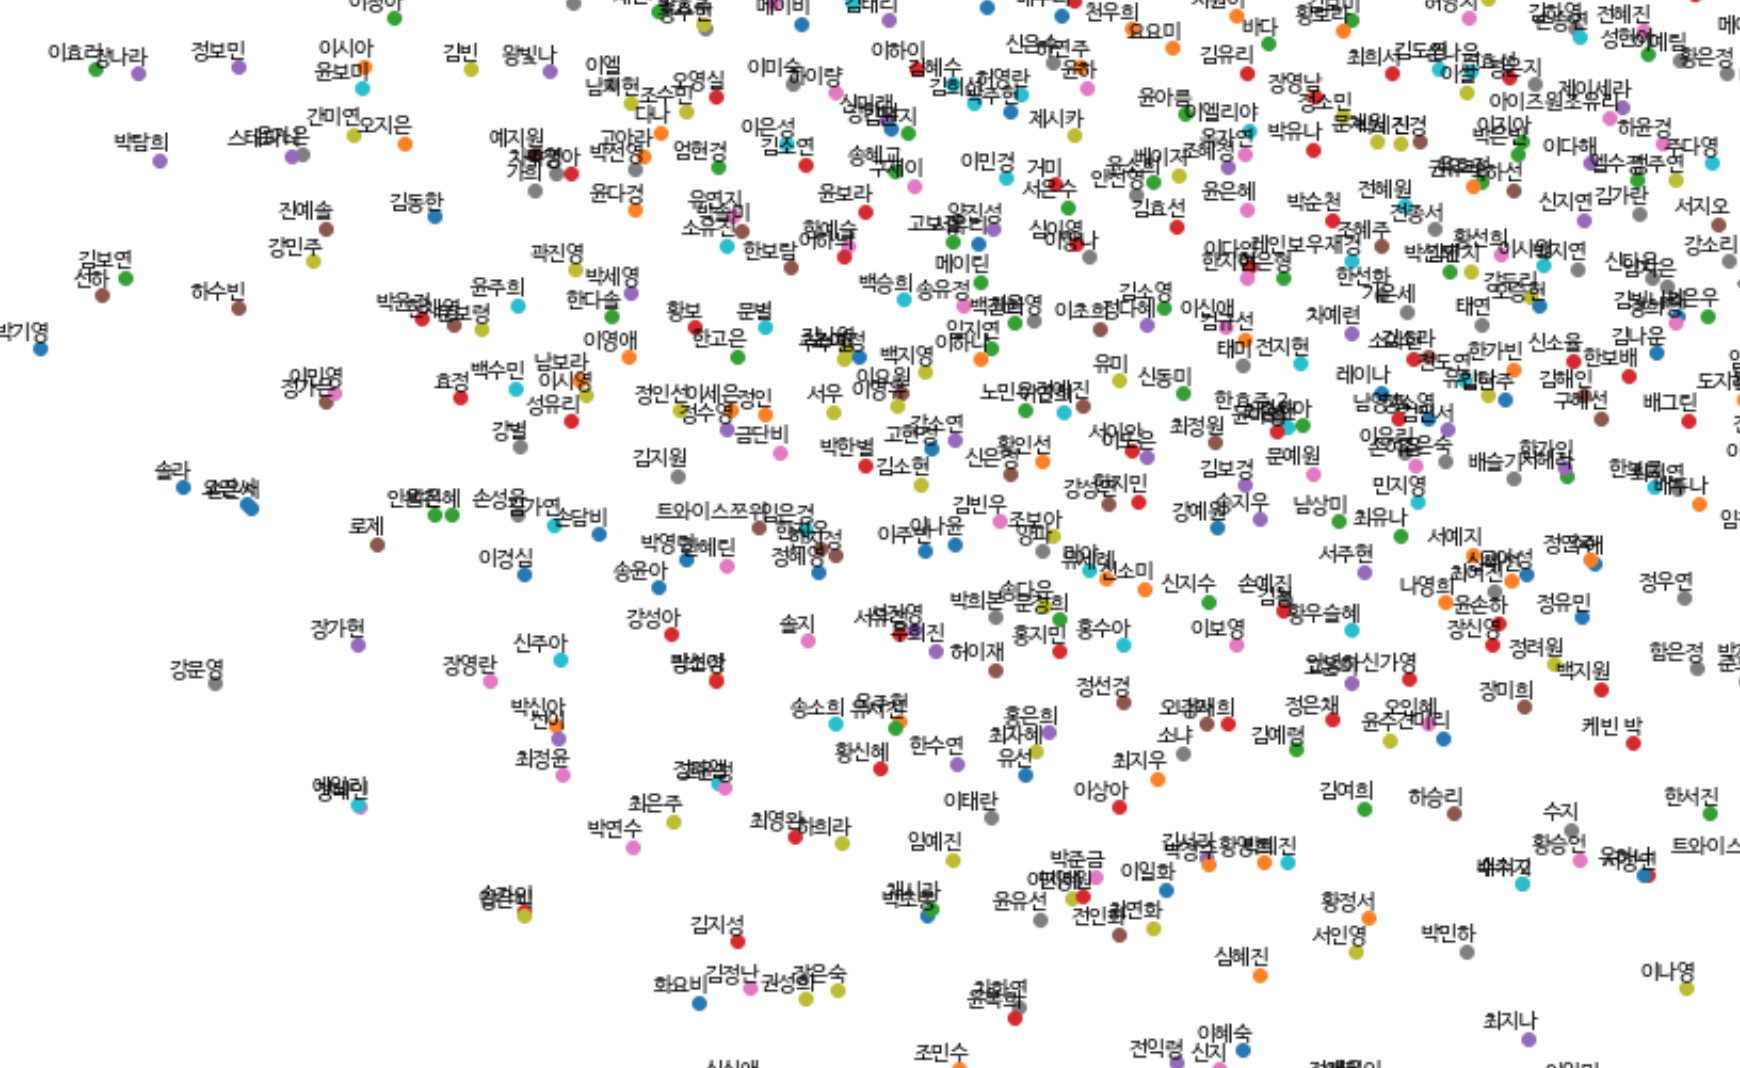

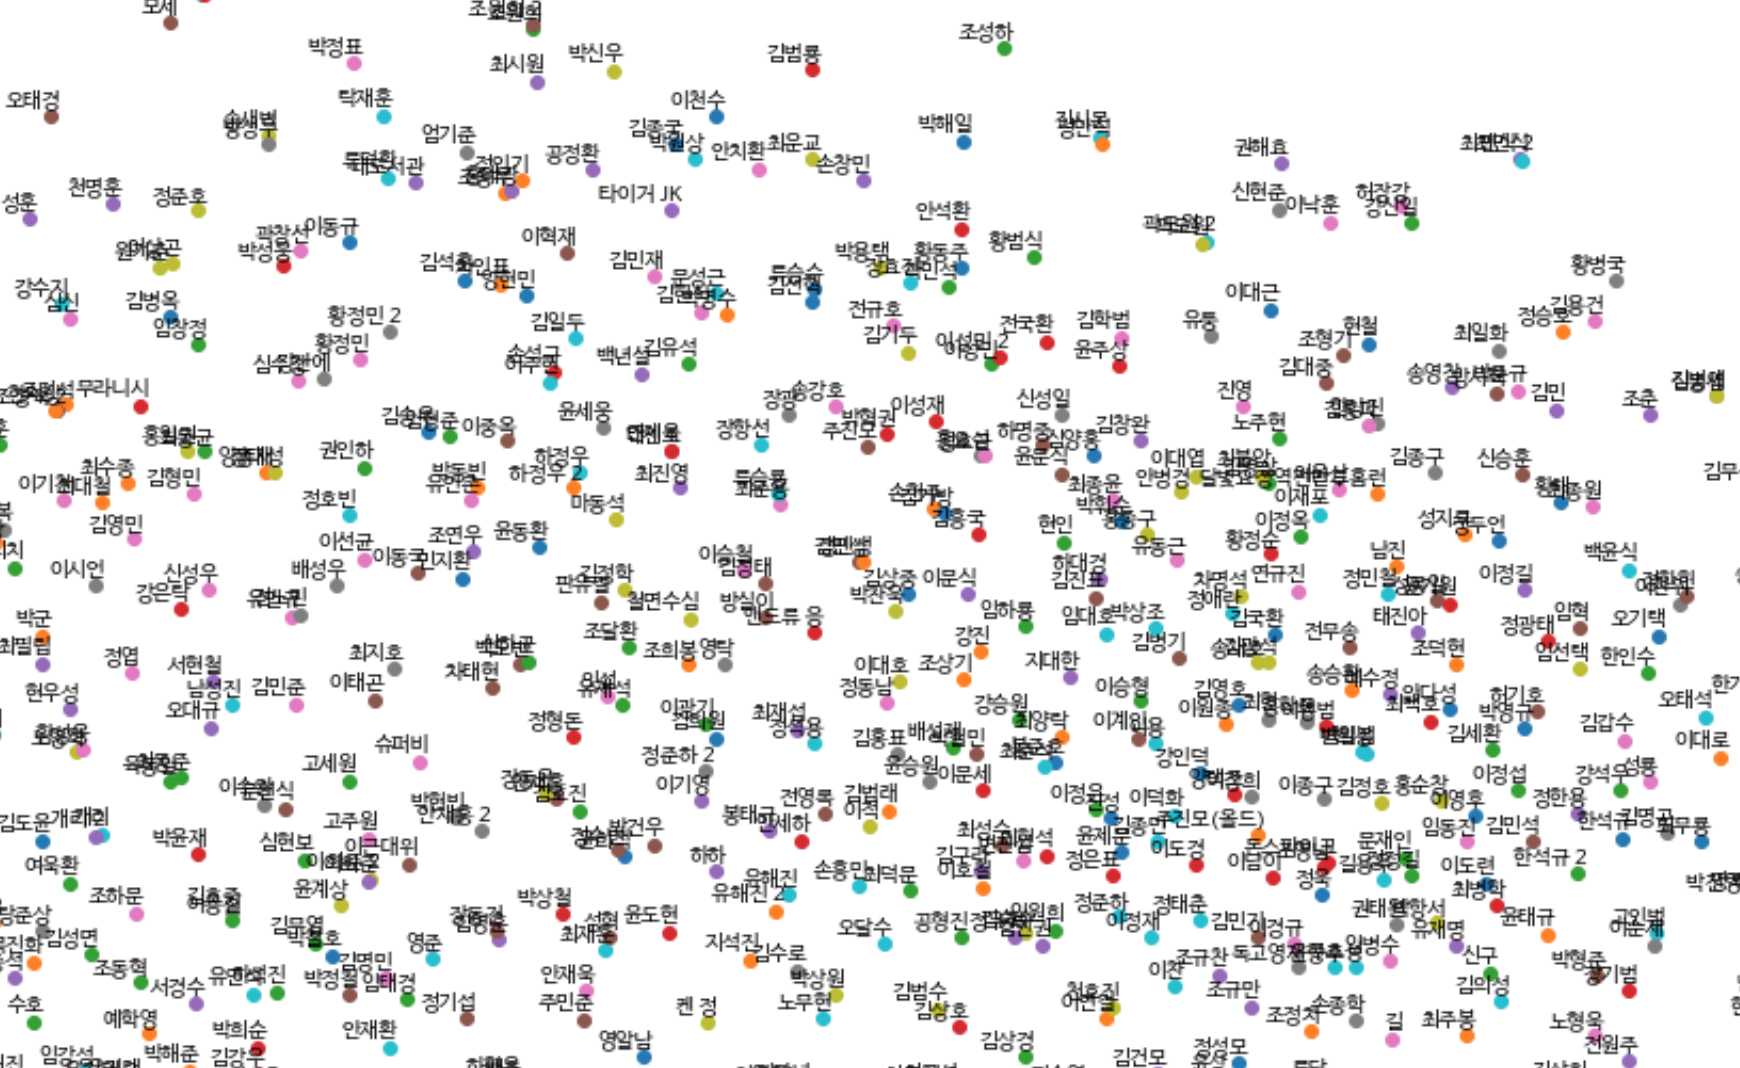

# 4. 회고
이미지는 몇천만 이상의 차원을 가진 숫자 배열로 표현됩니다. 상상할 수도 없는 고차원 벡터를 직접 일일이 비교하는 것은 당연히 불가능한 일이니, 기계의 도움을 받아야합니다. 이 고차원의 이미지 벡터에서 특성들을 추출해서 저차원 임베딩 벡터로 임베딩을 하는 것은 벡터 간 거리를 비교해서 비슷한 이미지들을 찾을 때 유용합니다. 예를 들면, 유사한 이미지들로 의류 쇼핑몰에서 유사 패션 상품을 골라줄수도 있고, 등 다양하게 활용 가능합니다.